<a href="https://colab.research.google.com/github/taareek/resume_classification/blob/main/ML_XGBoost_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nltk
!pip install gensim
!pip install wordcloud
!pip install PyPDF2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# loading train, test, and validation data
train_data_path = '/content/drive/MyDrive/IC_Evaluation/final_train.csv'
val_data_path = '/content/drive/MyDrive/IC_Evaluation/final_validation.csv'
test_data_path = '/content/drive/MyDrive/IC_Evaluation/final_test.csv'

In [ ]:
train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)
test_data = pd.read_csv(test_data_path)

In [ ]:
# train data
train_data.head(3)

,path,resume,category,category_label
0,/content/drive/MyDrive/IC_Evaluation/archive/d...,supervisor ountant professional summary motiva...,ACCOUNTANT,5
1,/content/drive/MyDrive/IC_Evaluation/archive/d...,program manager financial manager facilities m...,BANKING,7
2,/content/drive/MyDrive/IC_Evaluation/archive/d...,information technology manager summary dedicat...,INFORMATION-TECHNOLOGY,21


In [ ]:
# discarding rows if there any null values
train_data = train_data.dropna()

In [ ]:
train_data.isnull().sum()

path              0
resume            0
category          0
category_label    0
dtype: int64

Text(0.5, 1.0, 'Bar chart for each Resume category in train data')

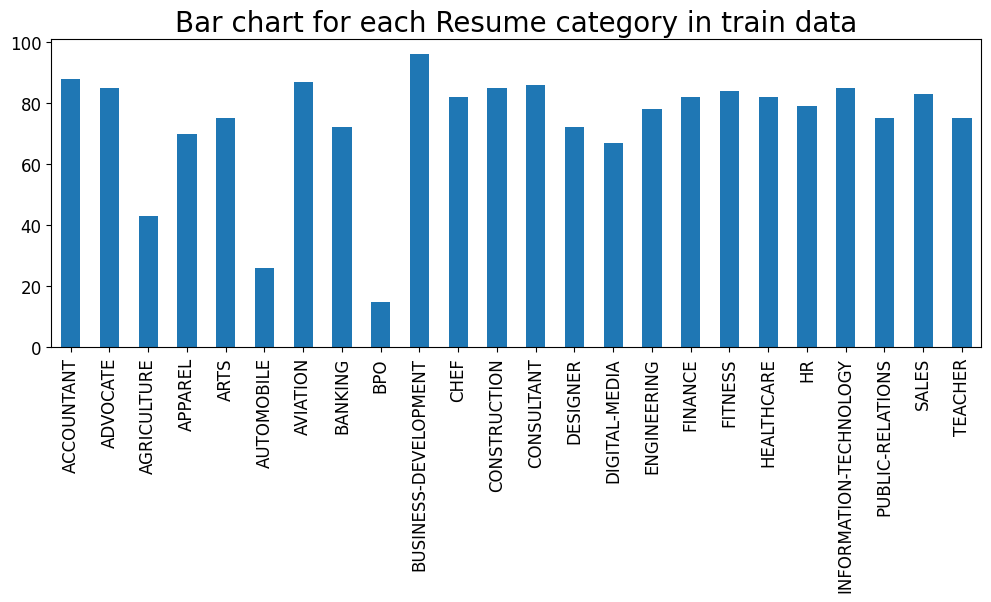

In [ ]:
# plotting bar chart for train data
train_data['category'].value_counts().sort_index().plot(kind='bar',
                                                             figsize=(12, 4),
                                                             fontsize= 12)
plt.title("Bar chart for each Resume category in train data", fontsize= 20)

In [ ]:
# test data head
test_data.head(2)

,path,resume,category,category_label
0,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,general liability claim representative summary...,AUTOMOBILE,0
1,/content/drive/MyDrive/IC_Evaluation/test/AUTO...,manager summary product manager bringing years...,AUTOMOBILE,0


In [ ]:
# discarding null values (if any)
test_data = test_data.dropna()

In [ ]:
test_data.isnull().sum()

path              0
resume            0
category          0
category_label    0
dtype: int64

Text(0.5, 1.0, 'Bar chart for each Resume category in test data')

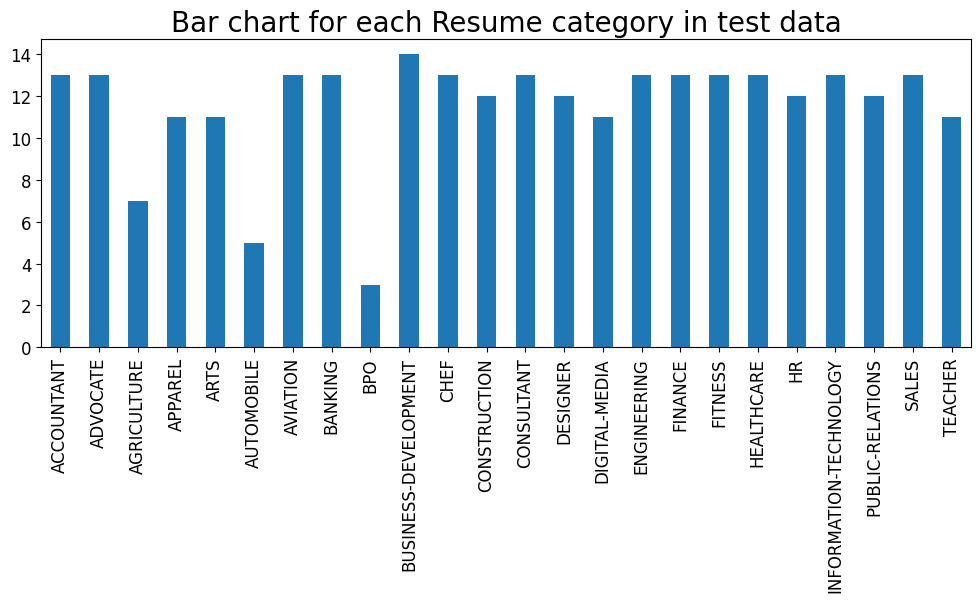

In [ ]:
# plotting for bar chart for test data
test_data['category'].value_counts().sort_index().plot(kind='bar',
                                                             figsize=(12, 4),
                                                             fontsize= 12)
plt.title("Bar chart for each Resume category in test data", fontsize= 20)

In [ ]:
# for validation data
val_data.head(2)

,path,resume,category,category_label
0,/content/drive/MyDrive/IC_Evaluation/archive/d...,customer advocate summary obtain position comp...,ADVOCATE,8
1,/content/drive/MyDrive/IC_Evaluation/archive/d...,co owner executive chef career focus performan...,CHEF,17


In [ ]:
# discarding null values (if any)
val_data = val_data.dropna()

In [ ]:
val_data.isnull().sum()

path              0
resume            0
category          0
category_label    0
dtype: int64

Text(0.5, 1.0, 'Bar chart for each Resume category in validation data')

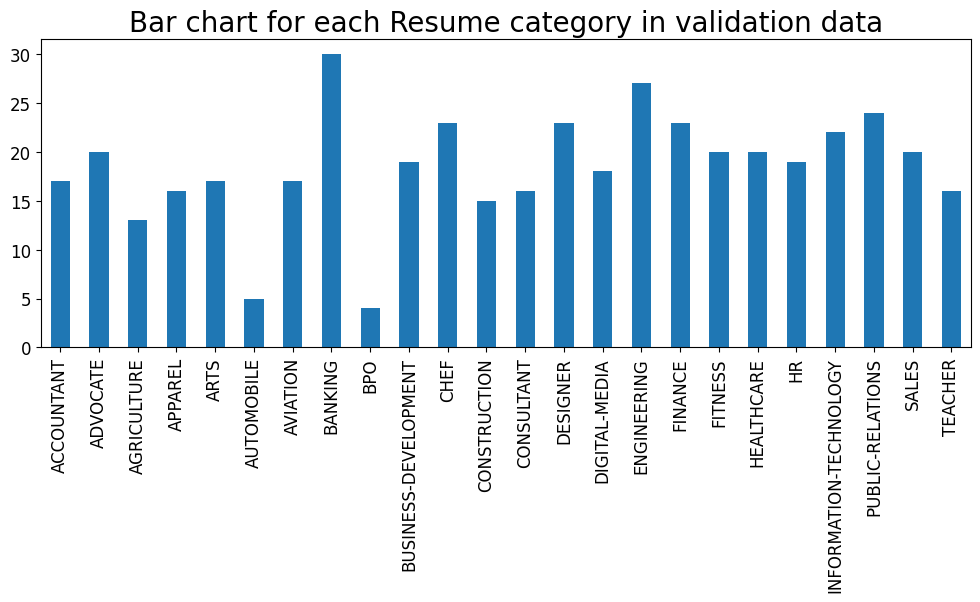

In [ ]:
# bar chart for validation data
val_data['category'].value_counts().sort_index().plot(kind='bar',
                                                             figsize=(12, 4),
                                                             fontsize= 12)
plt.title("Bar chart for each Resume category in validation data", fontsize= 20)

In [ ]:
## our defined category-integer mapping
labels_dict = {
    'AUTOMOBILE': 0,
    'AVIATION': 1,
    'BUSINESS-DEVELOPMENT': 2,
    'APPAREL': 3, 'ARTS': 4,
    'ACCOUNTANT': 5,
    'BPO': 6,
    'BANKING': 7,
    'ADVOCATE': 8,
    'AGRICULTURE': 9,
    'CONSTRUCTION': 10,
    'FITNESS': 11,
    'CONSULTANT': 12,
    'DIGITAL-MEDIA': 13,
    'ENGINEERING': 14,
    'DESIGNER': 15,
    'FINANCE': 16,
    'CHEF': 17,
    'HR': 18,
    'HEALTHCARE': 19,
    'PUBLIC-RELATIONS': 20,
    'INFORMATION-TECHNOLOGY': 21,
    'SALES': 22,
    'TEACHER': 23
    }

In [ ]:
# function to convert all characters in lower case and remove unnecessay characters and words
import re
import nltk

def preprocess_text(txt):
    # convert all characters in the string to lower case
    txt = txt.lower()
    # remove non-english characters, punctuation and numbers
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # remove RT and cc
    txt = re.sub('#\S+', '', txt)  # remove hashtags
    txt = re.sub('@\S+', '  ', txt)  # remove mentions
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace
    # tokenize word
    txt = nltk.tokenize.word_tokenize(txt)
    # remove stop words
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]

    return ' '.join(txt)

In [ ]:
# initializing NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import PyPDF2
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

In [ ]:
# function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

### developing and training XGBoost model

In [ ]:
# extracting features and splitting into train and test data
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# defining train, validation, test features and lables
train_resume = train_data['resume'].values
train_y = train_data['category_label'].values

val_resume = val_data['resume'].values
val_y = val_data['category_label'].values

test_resume = test_data['resume'].values
test_y = test_data['category_label'].values

# vectorizing resume texts
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')

word_vectorizer.fit(train_resume)

train_x = word_vectorizer.transform(train_resume)
val_x = word_vectorizer.transform(val_resume)
test_x = word_vectorizer.transform(test_resume)

# saving the feature extractor for further usage
pickle_out_word_vectorizer = open("/content/drive/MyDrive/IC_Evaluation/fe_xgb_tfid", "wb")
pickle.dump(word_vectorizer, pickle_out_word_vectorizer)
pickle_out_word_vectorizer.close()

print ("Feature extraction completed.....!")

Feature extraction completed.....!


In [ ]:
print(f"train data shape after feature extraction: {train_x.shape}")
print(f"validation data shape after feature extraction: {val_x.shape}")
print(f"test data shape after feature extraction: {test_x.shape}")

train data shape after feature extraction: (1772, 32008)
validation data shape after feature extraction: (444, 32008)
test data shape after feature extraction: (277, 32008)


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
import xgboost as xgb
from imblearn.metrics import specificity_score
from sklearn.metrics import classification_report

In [ ]:
xgb_model = xgb.XGBClassifier()

# fit to the model
xgb_model.fit(train_x, train_y)

# train accuracy
tr_score = xgb_model.score(train_x, train_y)
print(f"Training score of XGBoost: {100*tr_score:.2f}%")

# prediction for test data
prediction = xgb_model.predict(val_x)

# accuracy
acc = metrics.accuracy_score(val_y, prediction)
print(f"Accuracy: {100*acc:.2f}%")
# ROC-AUC
roc_auc = roc_auc_score(val_y, xgb_model.predict_proba(val_x),  multi_class="ovr")
print("ROC-AUC score is: ", round(100*roc_auc, 2), "%")

# Matthew's coefficent
mcc = matthews_corrcoef(val_y, prediction)
print("The Matthews correlation coefficinet (MCC) is: ", round(100*mcc, 2), "%")

# specificity
sp = specificity_score(val_y, prediction, average='weighted')
print(f"Weighted specificity: {100*sp:.2f}%")

# classification reports
print(classification_report(val_y, prediction))

Training score of XGBoost: 100.00%
Accuracy: 73.87%
ROC-AUC score is:  97.42 %
The Matthews correlation coefficinet (MCC) is:  72.71 %
Weighted specificity: 98.83%
              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.61      0.82      0.70        17
           2       0.62      0.84      0.71        19
           3       0.67      0.50      0.57        16
           4       0.63      0.71      0.67        17
           5       0.87      0.76      0.81        17
           6       0.67      0.50      0.57         4
           7       0.75      0.50      0.60        30
           8       0.88      0.75      0.81        20
           9       0.60      0.46      0.52        13
          10       0.76      0.87      0.81        15
          11       0.94      0.80      0.86        20
          12       0.62      0.62      0.62        16
          13       0.76      0.72      0.74        18
          14       0.84  

### applying feature selection

In [ ]:
## applying feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_features = SelectKBest(chi2, k = int((train_x.shape[1]*60)/100))

In [ ]:
chi2_features.fit(train_x, train_y)
train_x_s = chi2_features.transform(train_x)
val_x_s = chi2_features.transform(val_x)

print(train_x_s.shape)
print(val_x_s.shape)

(1772, 19204)
(444, 19204)


In [ ]:
# save feature selector
# saving the feature extractor for further usage
pickle_out_ft_selector = open("/content/drive/MyDrive/IC_Evaluation/ft_selection_xgb_tfid", "wb")
pickle.dump(chi2_features, pickle_out_ft_selector)
pickle_out_ft_selector.close()

In [ ]:
xgb_model = xgb.XGBClassifier()

# fit to the model
xgb_model.fit(train_x_s, train_y)

# train accuracy
tr_score = xgb_model.score(train_x_s, train_y)
print(f"Training score of XGBoost: {100*tr_score:.2f}%")

# prediction for test data
prediction = xgb_model.predict(val_x_s)

# accuracy
acc = metrics.accuracy_score(val_y, prediction)
print(f"Accuracy: {100*acc:.2f}%")
# ROC-AUC
roc_auc = roc_auc_score(val_y, xgb_model.predict_proba(val_x_s),  multi_class="ovr")
print("ROC-AUC score is: ", round(100*roc_auc, 2), "%")

# Matthew's coefficent
mcc = matthews_corrcoef(val_y, prediction)
print("The Matthews correlation coefficinet (MCC) is: ", round(100*mcc, 2), "%")

# specificity
sp = specificity_score(val_y, prediction, average='weighted')
print(f"Weighted specificity: {100*sp:.2f}%")

# classification reports
print(classification_report(val_y, prediction))

Training score of XGBoost: 100.00%
Accuracy: 76.58%
ROC-AUC score is:  97.51 %
The Matthews correlation coefficinet (MCC) is:  75.53 %
Weighted specificity: 98.93%
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.67      0.82      0.74        17
           2       0.68      0.89      0.77        19
           3       0.73      0.50      0.59        16
           4       0.57      0.71      0.63        17
           5       0.94      0.88      0.91        17
           6       1.00      0.50      0.67         4
           7       0.86      0.60      0.71        30
           8       0.89      0.80      0.84        20
           9       0.60      0.46      0.52        13
          10       0.87      0.87      0.87        15
          11       0.94      0.85      0.89        20
          12       0.67      0.50      0.57        16
          13       0.86      0.67      0.75        18
          14       0.89  

### tuning after feature selection

In [ ]:
# with our final model

model = xgb.XGBClassifier(
      learning_rate=0.01,
      colsample_bytree=0.8,
      subsample=0.8,
      objective='multi:softmax',
      n_estimators=200,
      reg_alpha=0.8,
      max_depth=11,
      gamma=9
  )

eval_set = [(train_x_s, train_y), (val_x_s, val_y)]
eval_metric = ["merror", "mlogloss"]  # Multi-class evaluation metrics

%time model.fit(train_x_s, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.27257	validation_0-mlogloss:3.12465	validation_1-merror:0.34910	validation_1-mlogloss:3.13038
[1]	validation_0-merror:0.23251	validation_0-mlogloss:3.07464	validation_1-merror:0.31757	validation_1-mlogloss:3.08609
[2]	validation_0-merror:0.20542	validation_0-mlogloss:3.03115	validation_1-merror:0.30631	validation_1-mlogloss:3.04809
[3]	validation_0-merror:0.19865	validation_0-mlogloss:2.98826	validation_1-merror:0.28604	validation_1-mlogloss:3.00908
[4]	validation_0-merror:0.19752	validation_0-mlogloss:2.94541	validation_1-merror:0.27477	validation_1-mlogloss:2.97044
[5]	validation_0-merror:0.18962	validation_0-mlogloss:2.90401	validation_1-merror:0.27477	validation_1-mlogloss:2.93250
[6]	validation_0-merror:0.18059	validation_0-mlogloss:2.86526	validation_1-merror:0.26577	validation_1-mlogloss:2.89805
[7]	validation_0-merror:0.17720	validation_0-mlogloss:2.82802	validation_1-merror:0.27252	validation_1-mlogloss:2.86404
[8]	validation_0-merror:0.17551	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

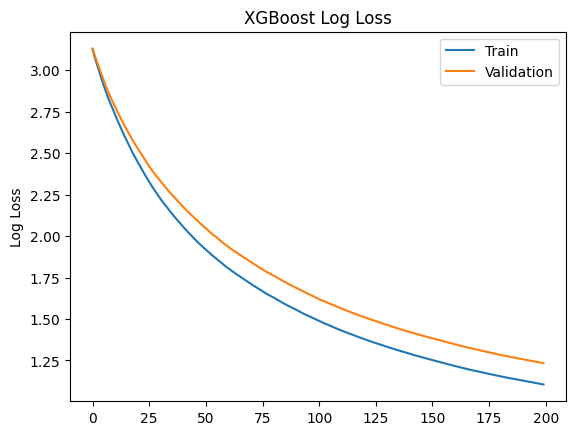

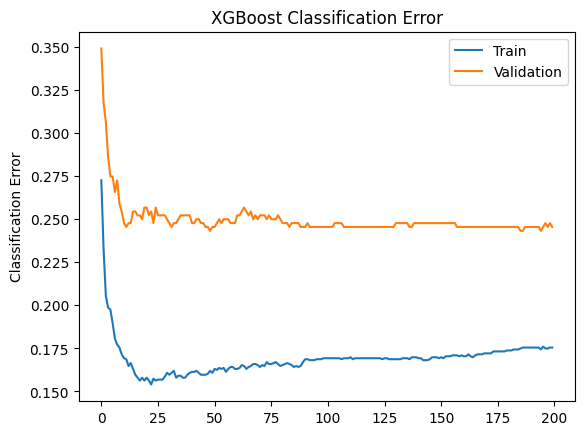

In [ ]:
# plotting training and validation loss and error
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
# function to get evaluation results

def get_evaluation(model, X_train, y_train, X_test, y_test):
  # train accuracy
  tr_score = model.score(X_train, y_train)
  print(f"Training score of XGBoost: {100*tr_score:.2f}%")

  # prediction for test data
  prediction = model.predict(X_test)

  # accuracy
  acc = metrics.accuracy_score(y_test, prediction)
  print(f"Accuracy: {100*acc:.2f}%")
  # ROC-AUC
  roc_auc = roc_auc_score(y_test, model.predict_proba(X_test),  multi_class="ovr")
  print("ROC-AUC score is: ", round(100*roc_auc, 2), "%")

  # Matthew's coefficent
  mcc = matthews_corrcoef(y_test, prediction)
  print("The Matthews correlation coefficinet (MCC) is: ", round(100*mcc, 2), "%")

  # specificity
  sp = specificity_score(y_test, prediction, average='weighted')
  print(f"Weighted specificity: {100*sp:.2f}%")

  # classification reports
  print(classification_report(y_test, prediction))

In [ ]:
# getting validation set results
get_evaluation(model, train_x_s, train_y, val_x_s, val_y)

Training score of XGBoost: 82.45%
Accuracy: 75.45%
ROC-AUC score is:  97.56 %
The Matthews correlation coefficinet (MCC) is:  74.35 %
Weighted specificity: 98.85%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.68      0.76      0.72        17
           2       0.71      0.89      0.79        19
           3       1.00      0.44      0.61        16
           4       0.52      0.65      0.58        17
           5       0.75      0.88      0.81        17
           6       0.00      0.00      0.00         4
           7       0.91      0.67      0.77        30
           8       0.73      0.80      0.76        20
           9       1.00      0.38      0.56        13
          10       0.76      0.87      0.81        15
          11       0.94      0.85      0.89        20
          12       0.92      0.69      0.79        16
          13       0.76      0.72      0.74        18
          14       0.85   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### tuning without feature selection

In [ ]:
# with our final model

model_ft = xgb.XGBClassifier(
      learning_rate=0.01,
      colsample_bytree=0.4,
      subsample=0.7,
      objective='multi:softmax',
      n_estimators=500,
      reg_alpha=0.9,
      max_depth=11,
      gamma=9
  )

eval_set = [(train_x, train_y), (val_x, val_y)]
eval_metric = ["merror", "mlogloss"]  # Multi-class evaluation metrics

%time model_ft.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.40971	validation_0-mlogloss:3.14166	validation_1-merror:0.48649	validation_1-mlogloss:3.14434
[1]	validation_0-merror:0.30926	validation_0-mlogloss:3.10518	validation_1-merror:0.42568	validation_1-mlogloss:3.11458
[2]	validation_0-merror:0.27935	validation_0-mlogloss:3.07408	validation_1-merror:0.38964	validation_1-mlogloss:3.08925
[3]	validation_0-merror:0.27540	validation_0-mlogloss:3.04551	validation_1-merror:0.36486	validation_1-mlogloss:3.06583
[4]	validation_0-merror:0.26072	validation_0-mlogloss:3.01588	validation_1-merror:0.35586	validation_1-mlogloss:3.04273
[5]	validation_0-merror:0.25282	validation_0-mlogloss:2.98629	validation_1-merror:0.34009	validation_1-mlogloss:3.01831
[6]	validation_0-merror:0.24210	validation_0-mlogloss:2.95262	validation_1-merror:0.33108	validation_1-mlogloss:2.98680
[7]	validation_0-merror:0.23420	validation_0-mlogloss:2.92217	validation_1-merror:0.30631	validation_1-mlogloss:2.95945
[8]	validation_0-merror:0.22968	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

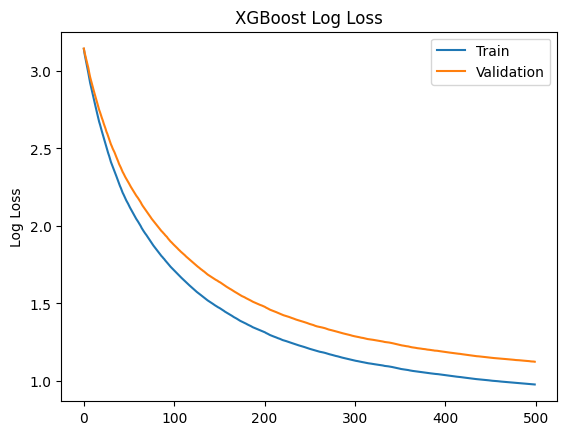

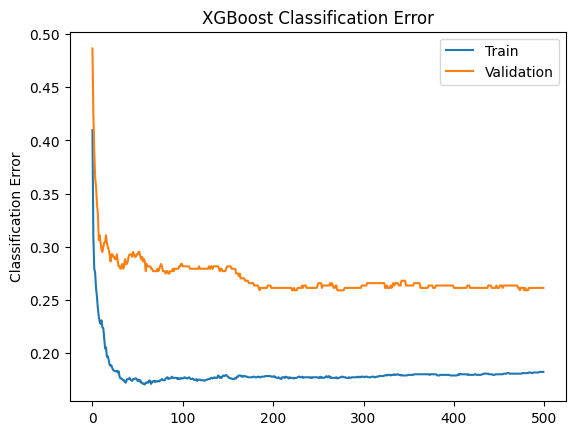

In [ ]:
# plotting training and validation loss and error
# retrieve performance metrics
results = model_ft.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
# getting validation set results
get_evaluation(model_ft, train_x, train_y, val_x, val_y)

Training score of XGBoost: 81.77%
Accuracy: 73.87%
ROC-AUC score is:  97.75 %
The Matthews correlation coefficinet (MCC) is:  72.75 %
Weighted specificity: 98.77%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.68      0.76      0.72        17
           2       0.63      0.89      0.74        19
           3       1.00      0.25      0.40        16
           4       0.58      0.65      0.61        17
           5       0.78      0.82      0.80        17
           6       0.00      0.00      0.00         4
           7       0.89      0.57      0.69        30
           8       0.67      0.70      0.68        20
           9       1.00      0.38      0.56        13
          10       0.75      0.80      0.77        15
          11       0.94      0.80      0.86        20
          12       0.80      0.75      0.77        16
          13       0.76      0.72      0.74        18
          14       0.85   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Trying with Multinomial naive-bayes classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb_model =  MultinomialNB(force_alpha=True)
mnb_model.fit(train_x_s, train_y)

MultinomialNB(force_alpha=True)

In [ ]:
# getting validation set results
get_evaluation(mnb_model, train_x_s, train_y, val_x_s, val_y)

Training score of XGBoost: 66.48%
Accuracy: 42.57%
ROC-AUC score is:  88.56 %
The Matthews correlation coefficinet (MCC) is:  41.33 %
Weighted specificity: 97.40%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.38      0.65      0.48        17
           2       0.16      0.89      0.27        19
           3       1.00      0.06      0.12        16
           4       0.25      0.06      0.10        17
           5       0.25      0.88      0.39        17
           6       0.00      0.00      0.00         4
           7       1.00      0.03      0.06        30
           8       0.37      0.35      0.36        20
           9       0.00      0.00      0.00        13
          10       0.64      0.60      0.62        15
          11       0.92      0.55      0.69        20
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        18
          14       0.53   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**saving the best model based on validation performance**

In [ ]:
# save the classifier as pickle
import pickle
pickle_out = open("/content/drive/MyDrive/IC_Evaluation/XGB_final", "wb")
pickle.dump(xgb_model, pickle_out)
pickle_out.close()

### loading trained feature extractor, selector and classifier to evaluate test data

In [ ]:
# getting multiclass feature selector pickle file
tfid_path = "/content/drive/MyDrive/IC_Evaluation/fe_xgb_tfid"
feats_in = open(tfid_path, "rb")
tfid_ft_extractor = pickle.load(feats_in)


# loading feature extractor
fs_path = "/content/drive/MyDrive/IC_Evaluation/ft_selection_xgb_tfid"
fs_in = open(fs_path, "rb")
fs_selector = pickle.load(fs_in)

# loading model
model_path = "/content/drive/MyDrive/IC_Evaluation/XGB_final"
model_in = open(model_path, 'rb')
loaded_model = pickle.load(model_in)

In [ ]:
## getting the data
test_resume = test_data['resume'].values
test_y = test_data['category_label'].values

In [ ]:
# extract features
test_ft = tfid_ft_extractor.transform(test_resume)
print(f"shape before feature extraction: {test_ft.shape}")
# feature selection
x_test = fs_selector.transform(test_ft)
print(f"shape after feature extraction: {x_test.shape}")

shape before feature extraction: (277, 32008)
shape after feature extraction: (277, 19204)


In [ ]:
# getting classification results
print(f"===========> classification results on the test data <================\n")
# prediction for test data
prediction = loaded_model.predict(x_test)

# accuracy
acc = metrics.accuracy_score(test_y, prediction)
print(f"Accuracy: {100*acc:.2f}%")

# ROC-AUC
roc_auc = roc_auc_score(test_y, model.predict_proba(x_test),  multi_class="ovr")
print("ROC-AUC score is: ", round(100*roc_auc, 2), "%")

# Matthew's coefficent
mcc = matthews_corrcoef(test_y, prediction)
print("The Matthews correlation coefficinet (MCC) is: ", round(100*mcc, 2), "%")

# specificity
sp = specificity_score(test_y, prediction, average='weighted')
print(f"Weighted specificity: {100*sp:.2f}%")

# classification reports
print(classification_report(test_y, prediction))

===========> classification results on the test data <================

Accuracy: 71.48%
ROC-AUC score is:  96.79 %
The Matthews correlation coefficinet (MCC) is:  70.21 %
Weighted specificity: 98.69%
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       1.00      0.69      0.82        13
           2       0.59      0.71      0.65        14
           3       0.55      0.55      0.55        11
           4       0.50      0.55      0.52        11
           5       0.87      1.00      0.93        13
           6       1.00      0.67      0.80         3
           7       0.62      0.38      0.48        13
           8       0.75      0.69      0.72        13
           9       0.50      0.43      0.46         7
          10       0.85      0.92      0.88        12
          11       0.73      0.85      0.79        13
          12       0.57      0.62      0.59        13
          13       0.64      0.64      0.6

### for the script

In [ ]:
# function to get sub direcotories name and subdirectories name with path
import os
from os import walk
import shutil
def get_subdir_name_n_path(src_path):
  sub_dir = []
  sub_dir_w_path = []
  # getting sub-directories
  for (dir_path, dir_names, file_names) in walk(src_path):
    sub_dir.extend(dir_names)
    break
  # assigning sub-directories name
  for i in range(len(sub_dir)):
    sub_path = os.path.join(src_path+'/'+sub_dir[i]+'/')
    sub_dir_w_path.append(sub_path)

  return sub_dir, sub_dir_w_path

In [ ]:
# function to get files within a sub-directory

def get_subdir_files(src_dir):
  sub_files = []
  only_names = []
  for file in os.listdir(src_dir):
    if(os.path.isfile(os.path.join(src_dir, file))):
      file_name = os.path.join(src_dir, file)
      sub_files.append(file_name)
      only_names.append(file)
  return sub_files, only_names

In [ ]:
# function to get all files within subdirectoris as well
def get_all_files_with_name(src_dir):
  all_files_path = []
  all_files_name = []
  for path, subdirs, files in os.walk(src_dir):
    for name in files:
      # file name with path
      file_name = os.path.join(path, name)
      all_files_path.append(file_name)
      # get the names
      all_files_name.append(name)
  return all_files_path, all_files_name

In [ ]:
# functon to create a directory
def make_directory(root_path, dir_name):
  # defining path
  path = os.path.join(root_path, dir_name)

  # we can give a directory name that already exist by mistake, therefore, using try except
  try:
    os.mkdir(path)
    print(f"Directory created successfully at: {path}")
  except OSError as error:
      print(error)
  return path

In [ ]:
# get only file name
def get_only_fname(src_path):
  only_names = []
  for path, subdirs, files in os.walk(dummy_path):
    for name in files:
      # file name with path
      file_name = os.path.join(path, name)
      only_names.append(name)
      # only the file name
      # print(name) # get the file name
  return only_names


In [ ]:
# now checking this function by creating a test directory, which is needed to move some data in the test folder
root_dir = '/content/drive/MyDrive/IC_Evaluation/'
test_path = make_directory(root_dir, 'dummy_test_3')

Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3


In [ ]:
test_fold_path = '/content/drive/MyDrive/IC_Evaluation/test'

# checking the function with our root directory
test_fold_names, test_fold_paths = get_subdir_name_n_path(test_fold_path)

In [ ]:
print(f"Total classes in test folder: {len(test_fold_names)}")

Total classes in test folder: 24


In [ ]:
# first of all, I will create 24 sub-directory for 24 classes according to their name
for i in range(len(test_fold_names)):
  # getting the corresponding files of current sub-directory
  sub_resumes_path, sub_resumes_name = get_subdir_files(test_fold_paths[i])

  for k in range(len(sub_resumes_path)):
    shutil.copy(sub_resumes_path[k], test_path+'/'+sub_resumes_name[k])

print("copy completed...!")

copy completed...!


In [ ]:
# now checking this function by creating a test directory, which is needed to move some data in the test folder
root_dir = '/content/drive/MyDrive/IC_Evaluation/'
test_path_2 = make_directory(root_dir, 'dummy_test_4')

Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_4


In [ ]:
# first of all, I will create 24 sub-directory for 24 classes according to their name
for i in range(len(test_fold_names)):
  # getting the corresponding files of current sub-directory
  sub_resumes_path, sub_resumes_name = get_subdir_files(test_fold_paths[i])

  for k in range(len(sub_resumes_path)):
    shutil.copy(sub_resumes_path[k], test_path_2+'/'+sub_resumes_name[k])

print("copy completed...!")

copy completed...!


In [ ]:
# checking files
dummy_test_3_path, dummy_test_3_name = get_all_files_with_name(test_path)
dummy_test_4_path, dummy_test_4_name = get_all_files_with_name(test_path_2)

print("Total test resumes copied to dummy test folder 3: ",len(dummy_test_3_path))
print("Total test resumes copied to dummy test folder 4: ",len(dummy_test_4_path))

print("Total test resumes names in dummy test folder 3: ",len(dummy_test_3_name))
print("Total test resumes names in dummy test folder 4: ",len(dummy_test_4_name))

Total test resumes copied to dummy test folder 3:  277
Total test resumes copied to dummy test folder 4:  277
Total test resumes names in dummy test folder 3:  277
Total test resumes names in dummy test folder 4:  277


In [ ]:
# take an input directory where the test resumes are kept
input_dir = test_path # in this case i am taking dummy test_3 folder

# read all the files from the given directory, and their names
all_test_resumes, all_resume_names = get_all_files_with_name(input_dir)
print('total test resumes with path: ',len(all_test_resumes))
print('total test resumes with only name: ',len(all_resume_names))

total test resumes with path:  277
total test resumes with only name:  277


In [ ]:
# now, all files should be read and extract raw data from those
# then processes those raw data
def process_resume(resumes):
  resume_text = []
  for i in range(len(resumes)):
    # getting text
    raw_text = extract_text_from_pdf(resumes[i])
    # preprocess those text
    processed_text = preprocess_text(raw_text)
    # append to the list
    resume_text.append(processed_text)
  return resume_text

In [ ]:
processed_resume_text = process_resume(all_test_resumes)
print('total resumes processed: ',len(processed_resume_text))
processed_resume_text[0]

total resumes processed:  277


'general liability claim representative summary claims representative highly motivated su ess driven several years experience insurance industry skills claims file management processes litigation resolution strong interpersonal communication skills self directed team player critical thinker experience general liability claim representative company name city state recognized continued outstanding customer service nominated synch award su essfully determine coverage communicate insured based application policy information facts allegations case aggressively investigate evaluate reserve negotiate assigned claims ordance best practices organize workflow maintain efficiency productivity recognized su essfully indentifying resources activities required properly investigate claims involving subrogation risk control fraud effectively manage litigated claims maintain ounts business partners ensure sustain quality results auto claims unit manager company name city state monitor performance team 

In [ ]:
# now we will extract features from resume text and perform feature selection
def feat_extract_n_select(resume_text):

  # getting multiclass feature selector pickle file
  tfid_path = "/content/drive/MyDrive/IC_Evaluation/fe_xgb_tfid"
  feats_in = open(tfid_path, "rb")
  tfid_ft_extractor = pickle.load(feats_in)

  # loading feature extractor
  fs_path = "/content/drive/MyDrive/IC_Evaluation/ft_selection_xgb_tfid"
  fs_in = open(fs_path, "rb")
  fs_selector = pickle.load(fs_in)

  resume_features = tfid_ft_extractor.transform(resume_text)
  selected_resume_feat = fs_selector.transform(resume_features)

  return selected_resume_feat

In [ ]:
# apply the function
X_test = feat_extract_n_select(processed_resume_text)
print("shape after feature selection: ", X_test.shape)

shape after feature selection:  (277, 19204)


In [ ]:
# getting list of text labels, as we will convert predicted numerical list into text
# and the file will be moved into predicted class folder
text_labels = list(labels_dict.keys())
print(text_labels)

['AUTOMOBILE', 'AVIATION', 'BUSINESS-DEVELOPMENT', 'APPAREL', 'ARTS', 'ACCOUNTANT', 'BPO', 'BANKING', 'ADVOCATE', 'AGRICULTURE', 'CONSTRUCTION', 'FITNESS', 'CONSULTANT', 'DIGITAL-MEDIA', 'ENGINEERING', 'DESIGNER', 'FINANCE', 'CHEF', 'HR', 'HEALTHCARE', 'PUBLIC-RELATIONS', 'INFORMATION-TECHNOLOGY', 'SALES', 'TEACHER']


In [ ]:
# our model prediction and categorization of resumes
import csv
def categorize_resumes(resumes, resume_names, resume_paths, labels_list, input_dir):
  # load model
  model_path = "/content/drive/MyDrive/IC_Evaluation/XGB_final"
  model_in = open(model_path, 'rb')
  loaded_model = pickle.load(model_in)

  categories_resumes = []
  a = 0
  for resume in resumes:
    resume_name = resume_names[a]
    resume_path = resume_paths[a]
    pred_categ_label = loaded_model.predict(resume)
    pred_categ_name = labels_list[int(pred_categ_label)]

    # appending file and predicted category into a list
    categories_resumes.append([resume_path, pred_categ_name])
    # print('file_path: ', resume_path)
    # print('filename: ', resume_name,'predicted: ', pred_categ_name)

    # defining destination folder name, input folder based on requirements
    dest_name= os.path.join(input_dir+'/'+pred_categ_name)
    # checking is there any folder named by the predicted class to the dest folder
    if(os.path.isdir(dest_name)):
      shutil.move(resume_path, dest_name+'/'+resume_name)
    else:
      new_dir = make_directory(input_dir+'/', pred_categ_name)
      shutil.move(resume_path, new_dir+'/'+resume_name)
    a+=1

  # making csv file
  print("All test resumes as categorized and moved into destination folder with corresponding class folders...!")

  # making csv file to the destination folder
  with open(input_dir+'/'+ 'categorized_resumes.csv', 'w', encoding='UTF8', newline='') as p:
    writer = csv.writer(p)
    writer.writerows(categories_resumes)

  print("CSV file for categorized resumes also added to the destination folder...!!")


In [ ]:
# categorize resume
categorize_resumes(X_test, all_resume_names, all_test_resumes, text_labels, input_dir)

Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/AUTOMOBILE
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/CONSULTANT
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/ARTS
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/AGRICULTURE
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/AVIATION
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/ENGINEERING
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/INFORMATION-TECHNOLOGY
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/SALES
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/HR
Directory created successfully at: /content/drive/MyDrive/IC_Evaluation/dummy_test_3/APPAREL
Directory created successfully at: /content/drive/